In [6]:
# IMPORTS

import pandas as pd
import h5py
import numpy as np
import sys
import matplotlib.pyplot as plt
import neurokit2 as nk
import random
import networkx as nx
import torch
from torch_geometric.datasets import KarateClub
from torch_geometric.utils import to_networkx # Visualization
import matplotlib.pyplot as plt
from torch.nn import Linear                   # Define layers
from torch_geometric.nn import GCNConv
from scipy.signal import savgol_filter
from scipy.ndimage import gaussian_filter1d 
import pywt # pip install PyWavelets
from scipy.signal import medfilt
import cv2 # pip install opencv-python  

ModuleNotFoundError: No module named 'pywt'

In [5]:
import pandas as pd
import numpy as np
import random
import h5py

def carregar_ecgs(unlabel, umdavb, rbbb, lbbb, sb, st, af, multilabel,
                  unlabel_offset=0, umdavb_offset=0, rbbb_offset=0,
                  lbbb_offset=0, sb_offset=0, st_offset=0, af_offset=0, multilabel_offset=0,
                  filtrado=False):
    """
    Carrega os ECGs e retorna:
      - X: array numpy com os traçados de ECG, shape (N, 12, num_amostras_por_sinal)
      - ids_ecgs: lista com os exam_id correspondentes
      - labels: array numpy de shape (N, 6), onde cada linha contém [UMdAVB, RBBB, LBBB, SB, ST, AF].
                Se todos forem 0, significa ECG normal (unlabel).

    Parâmetros:
      unlabel    : quantidade de ECGs normais
      umdavb     : quantidade de ECGs com UMdAVB (apenas essa doença)
      rbbb       : quantidade de ECGs com RBBB  (apenas essa doença)
      lbbb       : quantidade de ECGs com LBBB  (apenas essa doença)
      sb         : quantidade de ECGs com SB    (apenas essa doença)
      st         : quantidade de ECGs com ST    (apenas essa doença)
      af         : quantidade de ECGs com AF    (apenas essa doença)
      multilabel : quantidade de ECGs com pelo menos duas doenças simultâneas

      unlabel_offset    : índice de início (offset) para pegar ECGs normais
      umdavb_offset     : índice de início para UMdAVB
      rbbb_offset       : índice de início para RBBB
      lbbb_offset       : índice de início para LBBB
      sb_offset         : índice de início para SB
      st_offset         : índice de início para ST
      af_offset         : índice de início para AF
      multilabel_offset : índice de início para ECGs multilabel

      filtrado   : se True, carrega arquivos de ECG filtrados; caso contrário, carrega os brutos

    Exemplo de uso para pegar os primeiros 1000:
      carregar_ecgs(
        unlabel=1000, unlabel_offset=0,   # do 0 ao 999
        ...
      )
    E para depois pegar os próximos 1000:
      carregar_ecgs(
        unlabel=1000, unlabel_offset=1000, # do 1000 ao 1999
        ...
      )
    """
    caminho_arquivo = "../../Projeto/Database/exams.csv"
    dados = pd.read_csv(caminho_arquivo)

    # Arquivos HDF5 que vamos considerar
    arquivos_usados = [
        "exams_part0.hdf5", "exams_part1.hdf5", "exams_part2.hdf5", "exams_part3.hdf5",
        "exams_par4.hdf5",  "exams_part5.hdf5", "exams_part6.hdf5", "exams_part7.hdf5",
        "exams_par8.hdf5",  "exams_part9.hdf5", "exams_part10.hdf5", "exams_part11.hdf5",
        "exams_part12.hdf5","exams_part13.hdf5","exams_part14.hdf5","exams_part15.hdf5",
        "exams_part16.hdf5","exams_part17.hdf5"
    ]

    # ======================
    # 1) Filtrar pelo col14 nos arquivos_usados e col13=False, etc.
    # ======================
    ecg_normal_linhas = dados.index[
        (dados.iloc[:, 14].isin(arquivos_usados)) &
        (dados.iloc[:, 4] == False) &
        (dados.iloc[:, 5] == False) &
        (dados.iloc[:, 6] == False) &
        (dados.iloc[:, 7] == False) &
        (dados.iloc[:, 8] == False) &
        (dados.iloc[:, 9] == False)
    ]
    ecg_umdavb_linhas = dados.index[
        (dados.iloc[:, 14].isin(arquivos_usados)) &
        (dados.iloc[:, 4] == True)  &
        (dados.iloc[:, 5] == False) &
        (dados.iloc[:, 6] == False) &
        (dados.iloc[:, 7] == False) &
        (dados.iloc[:, 8] == False) &
        (dados.iloc[:, 9] == False) &
        (dados.iloc[:, 13] == False)
    ]
    ecg_rbbb_linhas = dados.index[
        (dados.iloc[:, 14].isin(arquivos_usados)) &
        (dados.iloc[:, 4] == False) &
        (dados.iloc[:, 5] == True)  &
        (dados.iloc[:, 6] == False) &
        (dados.iloc[:, 7] == False) &
        (dados.iloc[:, 8] == False) &
        (dados.iloc[:, 9] == False) &
        (dados.iloc[:, 13] == False)
    ]
    ecg_lbbb_linhas = dados.index[
        (dados.iloc[:, 14].isin(arquivos_usados)) &
        (dados.iloc[:, 4] == False) &
        (dados.iloc[:, 5] == False) &
        (dados.iloc[:, 6] == True)  &
        (dados.iloc[:, 7] == False) &
        (dados.iloc[:, 8] == False) &
        (dados.iloc[:, 9] == False) &
        (dados.iloc[:, 13] == False)
    ]
    ecg_sb_linhas = dados.index[
        (dados.iloc[:, 14].isin(arquivos_usados)) &
        (dados.iloc[:, 4] == False) &
        (dados.iloc[:, 5] == False) &
        (dados.iloc[:, 6] == False) &
        (dados.iloc[:, 7] == True)  &
        (dados.iloc[:, 8] == False) &
        (dados.iloc[:, 9] == False) &
        (dados.iloc[:, 13] == False)
    ]
    ecg_st_linhas = dados.index[
        (dados.iloc[:, 14].isin(arquivos_usados)) &
        (dados.iloc[:, 4] == False) &
        (dados.iloc[:, 5] == False) &
        (dados.iloc[:, 6] == False) &
        (dados.iloc[:, 7] == False) &
        (dados.iloc[:, 8] == True)  &
        (dados.iloc[:, 9] == False) &
        (dados.iloc[:, 13] == False)
    ]
    ecg_af_linhas = dados.index[
        (dados.iloc[:, 14].isin(arquivos_usados)) &
        (dados.iloc[:, 4] == False) &
        (dados.iloc[:, 5] == False) &
        (dados.iloc[:, 6] == False) &
        (dados.iloc[:, 7] == False) &
        (dados.iloc[:, 8] == False) &
        (dados.iloc[:, 9] == True)  &
        (dados.iloc[:, 13] == False)
    ]

    # Multilabel = pelo menos 2 doenças
    bool_sum = (
        dados.iloc[:, 4].astype(int) +
        dados.iloc[:, 5].astype(int) +
        dados.iloc[:, 6].astype(int) +
        dados.iloc[:, 7].astype(int) +
        dados.iloc[:, 8].astype(int) +
        dados.iloc[:, 9].astype(int)
    )
    ecg_multilabel_linhas = dados.index[
        (dados.iloc[:, 14].isin(arquivos_usados)) &
        (bool_sum >= 2) &
        (dados.iloc[:, 13] == False)
    ]

    print("Número de linhas ecg_normal_linhas:", len(ecg_normal_linhas))
    print("Número de linhas ecg_umdavb_linhas:", len(ecg_umdavb_linhas))
    print("Número de linhas ecg_rbbb_linhas:", len(ecg_rbbb_linhas))
    print("Número de linhas ecg_lbbb_linhas:", len(ecg_lbbb_linhas))
    print("Número de linhas ecg_sb_linhas:", len(ecg_sb_linhas))
    print("Número de linhas ecg_st_linhas:", len(ecg_st_linhas))
    print("Número de linhas ecg_af_linhas:", len(ecg_af_linhas))
    print("Número de linhas ecg_multilabel_linhas:", len(ecg_multilabel_linhas))

    # ======================
    # 2) Excluir exames com interferência
    # ======================
    caminho_interferencias = "../../Projeto/Database/resultados_interferencia.csv"
    interferencias = pd.read_csv(caminho_interferencias)
    interferencias_ids = interferencias['exam_id'].tolist()

    ecg_normal_linhas     = ecg_normal_linhas[~dados.loc[ecg_normal_linhas, 'exam_id'].isin(interferencias_ids)]
    ecg_umdavb_linhas     = ecg_umdavb_linhas[~dados.loc[ecg_umdavb_linhas, 'exam_id'].isin(interferencias_ids)]
    ecg_rbbb_linhas       = ecg_rbbb_linhas[~dados.loc[ecg_rbbb_linhas, 'exam_id'].isin(interferencias_ids)]
    ecg_lbbb_linhas       = ecg_lbbb_linhas[~dados.loc[ecg_lbbb_linhas, 'exam_id'].isin(interferencias_ids)]
    ecg_sb_linhas         = ecg_sb_linhas[~dados.loc[ecg_sb_linhas, 'exam_id'].isin(interferencias_ids)]
    ecg_st_linhas         = ecg_st_linhas[~dados.loc[ecg_st_linhas, 'exam_id'].isin(interferencias_ids)]
    ecg_af_linhas         = ecg_af_linhas[~dados.loc[ecg_af_linhas, 'exam_id'].isin(interferencias_ids)]
    ecg_multilabel_linhas = ecg_multilabel_linhas[~dados.loc[ecg_multilabel_linhas, 'exam_id'].isin(interferencias_ids)]

    print("\nTirando Interferência:")
    print("Número de linhas ecg_normal_linhas:", len(ecg_normal_linhas))
    print("Número de linhas ecg_umdavb_linhas:", len(ecg_umdavb_linhas))
    print("Número de linhas ecg_rbbb_linhas:", len(ecg_rbbb_linhas))
    print("Número de linhas ecg_lbbb_linhas:", len(ecg_lbbb_linhas))
    print("Número de linhas ecg_sb_linhas:", len(ecg_sb_linhas))
    print("Número de linhas ecg_st_linhas:", len(ecg_st_linhas))
    print("Número de linhas ecg_af_linhas:", len(ecg_af_linhas))
    print("Número de linhas ecg_multilabel_linhas:", len(ecg_multilabel_linhas))

    # ======================
    # 3) Obter exam_id de cada grupo
    # ======================
    ecg_normal_id      = dados.iloc[ecg_normal_linhas, 0].tolist()
    ecg_umdavb_id      = dados.iloc[ecg_umdavb_linhas, 0].tolist()
    ecg_rbbb_id        = dados.iloc[ecg_rbbb_linhas, 0].tolist()
    ecg_lbbb_id        = dados.iloc[ecg_lbbb_linhas, 0].tolist()
    ecg_sb_id          = dados.iloc[ecg_sb_linhas, 0].tolist()
    ecg_st_id          = dados.iloc[ecg_st_linhas, 0].tolist()
    ecg_af_id          = dados.iloc[ecg_af_linhas, 0].tolist()
    ecg_multilabel_id  = dados.iloc[ecg_multilabel_linhas, 0].tolist()

    # ======================
    # 4) Em vez de random.sample(...), usamos slicing com offset
    #    Ex.: ecg_normal_id[unlabel_offset : unlabel_offset + unlabel]
    # ======================
    # Se a lista for menor do que o offset, devolvemos lista vazia
    # Se a lista ainda tiver espaço após offset, pegamos a fatia
    def slice_ids(id_list, offset, count):
        if offset >= len(id_list):
            return []  # não há nada para pegar se offset estiver além do tamanho da lista
        return id_list[offset : offset + count]

    ecg_normal_sample     = slice_ids(ecg_normal_id,     unlabel_offset,    unlabel)
    ecg_umdavb_sample     = slice_ids(ecg_umdavb_id,     umdavb_offset,     umdavb)
    ecg_rbbb_sample       = slice_ids(ecg_rbbb_id,       rbbb_offset,       rbbb)
    ecg_lbbb_sample       = slice_ids(ecg_lbbb_id,       lbbb_offset,       lbbb)
    ecg_sb_sample         = slice_ids(ecg_sb_id,         sb_offset,         sb)
    ecg_st_sample         = slice_ids(ecg_st_id,         st_offset,         st)
    ecg_af_sample         = slice_ids(ecg_af_id,         af_offset,         af)
    ecg_multilabel_sample = slice_ids(ecg_multilabel_id, multilabel_offset, multilabel)

    # ======================
    # 5) Combina todos os IDs (ordem é a dada pela concatenação simples)
    # ======================
    ids_ecgs = (
        ecg_normal_sample +
        ecg_umdavb_sample +
        ecg_rbbb_sample +
        ecg_lbbb_sample +
        ecg_sb_sample +
        ecg_st_sample +
        ecg_af_sample +
        ecg_multilabel_sample
    )

    print("\nNúmero total de ECGs selecionados:", len(ids_ecgs))

    # ======================
    # 6) Selecionar caminhos HDF5 (filtrado ou não)
    # ======================
    if filtrado:
        arquivos_hdf5 = [
            "/scratch/guilherme.evangelista/Clustering-Paper/Projeto/Database/filtered_exams_0_1.hdf5",
            "/scratch/guilherme.evangelista/Clustering-Paper/Projeto/Database/filtered_exams_2_3.hdf5",
            "/scratch/guilherme.evangelista/Clustering-Paper/Projeto/Database/filtered_exams_4_5.hdf5",
            "/scratch/guilherme.evangelista/Clustering-Paper/Projeto/Database/filtered_exams_6_7.hdf5",
            "/scratch/guilherme.evangelista/Clustering-Paper/Projeto/Database/filtered_exams_8_9.hdf5",
            "/scratch/guilherme.evangelista/Clustering-Paper/Projeto/Database/filtered_exams_10_11.hdf5",
            "/scratch/guilherme.evangelista/Clustering-Paper/Projeto/Database/filtered_exams_12_13.hdf5",
            "/scratch/guilherme.evangelista/Clustering-Paper/Projeto/Database/filtered_exams_14_15.hdf5",
            "/scratch/guilherme.evangelista/Clustering-Paper/Projeto/Database/filtered_exams_16_17.hdf5"
        ]
    else:
        arquivos_hdf5 = [
            '/scratch/pedro.bacelar/Clustering-Paper/Projeto/Database/exams_part0.hdf5',
            '/scratch/pedro.bacelar/Clustering-Paper/Projeto/Database/exams_part1.hdf5',
            '/scratch/pedro.bacelar/Clustering-Paper/Projeto/Database/exams_part2.hdf5',
            '/scratch/pedro.bacelar/Clustering-Paper/Projeto/Database/exams_part3.hdf5',
            '/scratch/pedro.bacelar/Clustering-Paper/Projeto/Database/exams_part4.hdf5',
            '/scratch/pedro.bacelar/Clustering-Paper/Projeto/Database/exams_part5.hdf5',
            '/scratch/pedro.bacelar/Clustering-Paper/Projeto/Database/exams_part6.hdf5',
            '/scratch/pedro.bacelar/Clustering-Paper/Projeto/Database/exams_part7.hdf5',
            '/scratch/pedro.bacelar/Clustering-Paper/Projeto/Database/exams_part8.hdf5',
            '/scratch/pedro.bacelar/Clustering-Paper/Projeto/Database/exams_part9.hdf5',
            '/scratch/pedro.bacelar/Clustering-Paper/Projeto/Database/exams_part10.hdf5',
            '/scratch/pedro.bacelar/Clustering-Paper/Projeto/Database/exams_part11.hdf5',
            '/scratch/pedro.bacelar/Clustering-Paper/Projeto/Database/exams_part12.hdf5',
            '/scratch/pedro.bacelar/Clustering-Paper/Projeto/Database/exams_part13.hdf5',
            '/scratch/pedro.bacelar/Clustering-Paper/Projeto/Database/exams_part14.hdf5',
            '/scratch/pedro.bacelar/Clustering-Paper/Projeto/Database/exams_part15.hdf5',
            '/scratch/pedro.bacelar/Clustering-Paper/Projeto/Database/exams_part16.hdf5',
            '/scratch/pedro.bacelar/Clustering-Paper/Projeto/Database/exams_part17.hdf5'
        ]

    # ======================
    # 7) Função auxiliar para ler o exame no HDF5
    # ======================
    def get_ecg_data(file_path, exam_id):
        with h5py.File(file_path, 'r') as f:
            exam_ids = np.array(f['exam_id'])
            exam_index = np.where(exam_ids == exam_id)[0]
            if len(exam_index) == 0:
                raise ValueError("Exam ID não encontrado.")
            exam_index = exam_index[0]
            exam_tracings = f['tracings'][exam_index]
            return exam_tracings

    # ======================
    # 8) Carrega os traçados
    # ======================
    all_tracings = []
    for exam_id in ids_ecgs:
        found = False
        for arquivo in arquivos_hdf5:
            try:
                tracings = get_ecg_data(arquivo, exam_id)
                if tracings is not None:
                    # Transpõe para shape (12, n_amostras)
                    tracing_transposto = np.array(tracings).T
                    all_tracings.append(tracing_transposto)
                    found = True
                    break
            except ValueError:
                # Se não achou esse exam_id nesse arquivo, pula
                pass
            except Exception as e:
                # Se houver outro erro, também só ignore
                pass

        if not found:
            print(f"Erro: exame ID {exam_id} não encontrado em nenhum dos arquivos.")

    print("\nNúmero de ecgs que eram pra ser processados:", len(ids_ecgs))
    print(f"Número total de traçados efetivamente carregados: {len(all_tracings)}")

    # ======================
    # 9) Monta X e as labels
    # ======================
    # X -> (N, 12, num_amostras)
    X = np.array(all_tracings)

    # labels -> (N, 6) => [UMdAVB, RBBB, LBBB, SB, ST, AF]
    labels = []
    for eid in ids_ecgs:
        row = dados.loc[dados['exam_id'] == eid]
        if len(row) == 0:
            labels.append([0, 0, 0, 0, 0, 0])
        else:
            row = row.iloc[0]
            label = [
                int(row.iloc[4]),  # UMdAVB
                int(row.iloc[5]),  # RBBB
                int(row.iloc[6]),  # LBBB
                int(row.iloc[7]),  # SB
                int(row.iloc[8]),  # ST
                int(row.iloc[9])   # AF
            ]
            labels.append(label)

    labels = np.array(labels, dtype=int)

    return X, ids_ecgs, labels




In [12]:

X, ids_ecgs, labels = carregar_ecgs(unlabel=10,umdavb=0, rbbb=0, lbbb=0, sb=0, st=0, af=0, multilabel=0,unlabel_offset=0, umdavb_offset=0, rbbb_offset=0,
                                    lbbb_offset=0, sb_offset=0, st_offset=0, af_offset=0, multilabel_offset=0,filtrado=True)


Número de linhas ecg_normal_linhas: 272407
Número de linhas ecg_umdavb_linhas: 3735
Número de linhas ecg_rbbb_linhas: 6808
Número de linhas ecg_lbbb_linhas: 4176
Número de linhas ecg_sb_linhas: 4300
Número de linhas ecg_st_linhas: 6146
Número de linhas ecg_af_linhas: 4964
Número de linhas ecg_multilabel_linhas: 3243

Tirando Interferência:
Número de linhas ecg_normal_linhas: 252167
Número de linhas ecg_umdavb_linhas: 3651
Número de linhas ecg_rbbb_linhas: 6703
Número de linhas ecg_lbbb_linhas: 4122
Número de linhas ecg_sb_linhas: 4248
Número de linhas ecg_st_linhas: 6038
Número de linhas ecg_af_linhas: 4804
Número de linhas ecg_multilabel_linhas: 3169

Número total de ECGs selecionados: 10

Número de ecgs que eram pra ser processados: 10
Número total de traçados efetivamente carregados: 10


In [13]:

# Vamos imprimir um exemplo de 10 exames, mostrando seu exam_id e respectivo label
for i in range(min(10, len(ids_ecgs))):
    print(f"Exam ID: {ids_ecgs[i]}, Label: {labels[i]}")


Exam ID: 1169160, Label: [0 0 0 0 0 0]
Exam ID: 2873686, Label: [0 0 0 0 0 0]
Exam ID: 271011, Label: [0 0 0 0 0 0]
Exam ID: 384368, Label: [0 0 0 0 0 0]
Exam ID: 2950575, Label: [0 0 0 0 0 0]
Exam ID: 1467619, Label: [0 0 0 0 0 0]
Exam ID: 1537328, Label: [0 0 0 0 0 0]
Exam ID: 981735, Label: [0 0 0 0 0 0]
Exam ID: 1237983, Label: [0 0 0 0 0 0]
Exam ID: 2854912, Label: [0 0 0 0 0 0]


In [38]:
import torch
import numpy as np
import neurokit2 as nk
from ts2vg import NaturalVG
from torch_geometric.data import Data
from joblib import Parallel, delayed
from tqdm import tqdm

DEBUG = True  # Flag para mensagens de depuração

def debug_print(msg):
    if DEBUG:
        print("[DEBUG]", msg)

def compute_node_features(time_series, edges):
    """
    Calcula as features de cada nó:
      - amplitude: valor da amostra;
      - derivada: diferença com o nó anterior (primeiro nó = 0);
      - grau: número de arestas incidentes;
      - pagerank: valor de pagerank calculado via NetworkX.
    """
    import networkx as nx
    n = len(time_series)
    amplitude = time_series.reshape(-1, 1)
    derivative = np.concatenate(([0], np.diff(time_series))).reshape(-1, 1)
    
    if edges:
        edges_array = np.array(edges)
        u, v = edges_array[:, 0], edges_array[:, 1]
        counts = np.bincount(np.concatenate([u, v]), minlength=n)
    else:
        counts = np.zeros(n)
    degree = counts.reshape(-1, 1)
    
    # Cálculo do PageRank
    if edges:
        G = nx.Graph()
        G.add_nodes_from(range(n))
        G.add_edges_from(edges)
        pr = nx.pagerank(G)
        pagerank_arr = np.array([pr[i] for i in range(n)]).reshape(-1, 1)
    else:
        pagerank_arr = np.zeros((n, 1))
        
    features = np.hstack([amplitude, derivative, degree, pagerank_arr])
    return features

def get_middle_r_peak(lead_series, sampling_rate=400):
    """
    Detecta os picos R na lead utilizando nk.ecg_findpeaks e retorna o pico "do meio".
    """
    peaks_dict = nk.ecg_findpeaks(lead_series, sampling_rate=sampling_rate)
    peaks = np.array(peaks_dict["ECG_R_Peaks"])
    
    if peaks.size == 0:
        debug_print("Nenhum pico R encontrado; usando índice central")
        return len(lead_series) // 2
    
    if len(peaks) % 2 == 0:
        middle_index = peaks[len(peaks) // 2 - 1]
    else:
        middle_index = peaks[len(peaks) // 2]
    
    debug_print(f"Detectado pico R do meio: {middle_index}")
    return middle_index

def process_exam(ecg, exam_id, label):
    """
    Processa um exame (ECG) com 12 leads e retorna:
      - exam_id
      - objeto Data do PyTorch Geometric com:
            • edge_index calculado exatamente como no processamento isolado da lead 1 (como no método 1)
            • node_features obtidas como a concatenação horizontal das features (4 features por lead) de todas as 12 leads,
              usando a janela determinada pela lead 1.
      - label associada ao exame.
    
    Se a janela determinada pela lead 1 não tiver 1000 pontos, o exame é marcado como inválido e as features são zeradas.
    """
    debug_print(f"Processando exame: {exam_id}")
    
    # Determina a janela utilizando a lead 1 (mesmo que no método 1)
    lead1_series = ecg[1]
    r_peak = get_middle_r_peak(lead1_series, sampling_rate=400)
    start_index = max(0, r_peak - 500)
    end_index = min(len(lead1_series), r_peak + 500)
    debug_print(f"Exam {exam_id} - lead 1: r_peak = {r_peak}, start = {start_index}, end = {end_index}")
    
    if (end_index - start_index) != 1000:
        debug_print(f"Exam {exam_id}: janela inválida com {end_index - start_index} pontos.")
        node_features = np.zeros((1000, 48))
        edge_index = torch.empty((2, 0), dtype=torch.int64)
        valid = False
    else:
        valid = True
        # Processamento da lead 1 para o grafo (edge_index)
        seg_lead1 = lead1_series[start_index:end_index]
        vg_lead1 = NaturalVG()
        vg_lead1.build(seg_lead1)
        if vg_lead1.edges:
            edge_index = torch.tensor(vg_lead1.edges, dtype=torch.int64).t().contiguous()
        else:
            edge_index = torch.empty((2, 0), dtype=torch.int64)
        debug_print(f"Exam {exam_id} - lead 1: {len(vg_lead1.edges)} arestas")
        
        # Para cada uma das 12 leads, extrai a janela definida pela lead 1 e calcula as features
        features_list = []
        for lead in range(12):
            seg = ecg[lead][start_index:end_index]
            vg_temp = NaturalVG()
            vg_temp.build(seg)
            feat = compute_node_features(seg, vg_temp.edges)
            features_list.append(feat)
            debug_print(f"Exam {exam_id} - lead {lead}: seg shape = {seg.shape}, {len(vg_temp.edges)} arestas, feat shape = {feat.shape}")
        # Concatena horizontalmente: (1000, 4*12 = 48)
        node_features = np.hstack(features_list)
        debug_print(f"Exam {exam_id}: node_features shape = {node_features.shape}")
    
    data = Data(x=torch.tensor(node_features, dtype=torch.float32), edge_index=edge_index)
    return exam_id, data, label, valid

if __name__ == '__main__':
    # SUPOSIÇÕES:
    # - X: lista/array de ECGs, onde cada ECG tem shape (12, n_samples)
    # - ids_ecgs: lista de exam_ids, na mesma ordem de X.
    # - labels: lista/array de labels
    exam_ids_list = ids_ecgs  # deve estar definido
    labels_list = labels      # deve estar definido

    print("Processando exames para método 2 (armazenando apenas o grafo da lead 1 e 48 features por nó)...")
    results = Parallel(n_jobs=-1, verbose=10)(
        delayed(process_exam)(ecg, exam_ids_list[idx], labels_list[idx])
        for idx, ecg in enumerate(tqdm(X, desc="Processando exames"))
    )
    
    graphs_by_exam = {}
    for exam_id, data, label, valid in results:
        graphs_by_exam[exam_id] = {"grafo": data, "label": label}
    
    dados_salvos = {"grafos": graphs_by_exam}
    output_filename = "exames_com_labels.pt"
    torch.save(dados_salvos, output_filename)
    print(f"Grafos salvos com sucesso em {output_filename}")


Processando exames para método 2 (armazenando apenas o grafo da lead 1 e 48 features por nó)...


Processando exames: 100%|██████████| 10/10 [00:00<00:00, 20370.59it/s]


[DEBUG] Processando exame: 1169160
[DEBUG] Detectado pico R do meio: 1932
[DEBUG] Exam 1169160 - lead 1: r_peak = 1932, start = 1432, end = 2432
[DEBUG] Exam 1169160 - lead 1: 8960 arestas
[DEBUG] Exam 1169160 - lead 0: seg shape = (1000,), 8540 arestas, feat shape = (1000, 4)
[DEBUG] Exam 1169160 - lead 1: seg shape = (1000,), 8960 arestas, feat shape = (1000, 4)
[DEBUG] Exam 1169160 - lead 2: seg shape = (1000,), 7249 arestas, feat shape = (1000, 4)
[DEBUG] Exam 1169160 - lead 3: seg shape = (1000,), 8690 arestas, feat shape = (1000, 4)
[DEBUG] Exam 1169160 - lead 4: seg shape = (1000,), 7367 arestas, feat shape = (1000, 4)
[DEBUG] Exam 1169160 - lead 5: seg shape = (1000,), 7829 arestas, feat shape = (1000, 4)
[DEBUG] Exam 1169160 - lead 6: seg shape = (1000,), 7282 arestas, feat shape = (1000, 4)
[DEBUG] Exam 1169160 - lead 7: seg shape = (1000,), 10626 arestas, feat shape = (1000, 4)
[DEBUG] Exam 1169160 - lead 8: seg shape = (1000,), 15306 arestas, feat shape = (1000, 4)
[DEBUG] 

[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    9.6s finished


[DEBUG] Processando exame: 384368
[DEBUG] Detectado pico R do meio: 2049
[DEBUG] Exam 384368 - lead 1: r_peak = 2049, start = 1549, end = 2549
[DEBUG] Exam 384368 - lead 1: 15685 arestas
[DEBUG] Processando exame: 2950575
[DEBUG] Detectado pico R do meio: 1717
[DEBUG] Exam 2950575 - lead 1: r_peak = 1717, start = 1217, end = 2217
[DEBUG] Exam 2950575 - lead 1: 13454 arestas
[DEBUG] Processando exame: 1537328
[DEBUG] Detectado pico R do meio: 2081
[DEBUG] Exam 1537328 - lead 1: r_peak = 2081, start = 1581, end = 2581
[DEBUG] Exam 1537328 - lead 1: 18670 arestas
[DEBUG] Processando exame: 981735
[DEBUG] Detectado pico R do meio: 1895
[DEBUG] Exam 981735 - lead 1: r_peak = 1895, start = 1395, end = 2395
[DEBUG] Exam 981735 - lead 1: 28110 arestas
[DEBUG] Processando exame: 1467619
[DEBUG] Detectado pico R do meio: 1810
[DEBUG] Exam 1467619 - lead 1: r_peak = 1810, start = 1310, end = 2310
[DEBUG] Exam 1467619 - lead 1: 30008 arestas
[DEBUG] Processando exame: 1237983
[DEBUG] Detectado pic

[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed:   13.0s remaining:   30.4s
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:   13.2s remaining:   13.2s


[DEBUG] Exam 2950575 - lead 11: seg shape = (1000,), 24513 arestas, feat shape = (1000, 4)
[DEBUG] Exam 2950575: node_features shape = (1000, 48)
[DEBUG] Exam 1537328 - lead 9: seg shape = (1000,), 22270 arestas, feat shape = (1000, 4)
[DEBUG] Exam 981735 - lead 5: seg shape = (1000,), 27399 arestas, feat shape = (1000, 4)
[DEBUG] Exam 1537328 - lead 10: seg shape = (1000,), 26369 arestas, feat shape = (1000, 4)
[DEBUG] Exam 981735 - lead 6: seg shape = (1000,), 17163 arestas, feat shape = (1000, 4)
[DEBUG] Exam 1467619 - lead 8: seg shape = (1000,), 22666 arestas, feat shape = (1000, 4)
[DEBUG] Exam 1537328 - lead 11: seg shape = (1000,), 20716 arestas, feat shape = (1000, 4)
[DEBUG] Exam 1537328: node_features shape = (1000, 48)
[DEBUG] Exam 2873686 - lead 11: seg shape = (1000,), 15591 arestas, feat shape = (1000, 4)
[DEBUG] Exam 2873686: node_features shape = (1000, 48)
[DEBUG] Exam 981735 - lead 7: seg shape = (1000,), 22226 arestas, feat shape = (1000, 4)
[DEBUG] Exam 1467619 - l

[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:   13.2s remaining:    5.7s


[DEBUG] Exam 1467619 - lead 10: seg shape = (1000,), 67217 arestas, feat shape = (1000, 4)
[DEBUG] Exam 981735 - lead 10: seg shape = (1000,), 24800 arestas, feat shape = (1000, 4)
[DEBUG] Exam 981735 - lead 11: seg shape = (1000,), 11368 arestas, feat shape = (1000, 4)
[DEBUG] Exam 981735: node_features shape = (1000, 48)
[DEBUG] Exam 1467619 - lead 11: seg shape = (1000,), 31015 arestas, feat shape = (1000, 4)
[DEBUG] Exam 1467619: node_features shape = (1000, 48)
Grafos salvos com sucesso em exames_com_labels.pt


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   13.5s finished


In [7]:
import torch
import numpy as np
import neurokit2 as nk
import networkx as nx  # Para calcular PageRank
from ts2vg import NaturalVG
from torch_geometric.data import Data
from joblib import Parallel, delayed
from tqdm import tqdm

def compute_node_features(time_series, edges):
    """
    Calcula as features de cada nó:
      - amplitude: valor da amostra;
      - derivada: diferença com o nó anterior (primeiro nó = 0);
      - grau: número de arestas incidentes;
      - pagerank: valor de pagerank calculado via NetworkX.
    
    Parâmetros:
      time_series: numpy array de forma (n,) com os valores da lead.
      edges: lista de tuplas (i, j) definindo as arestas do grafo.
      
    Retorna:
      features: numpy array de forma (n, 4) com
                [amplitude, derivada, grau, pagerank] para cada nó.
    """
    n = len(time_series)
    amplitude = time_series.reshape(-1, 1)
    derivative = np.concatenate(([0], np.diff(time_series))).reshape(-1, 1)
    
    if edges:
        edges_array = np.array(edges)
        # Separa nós de origem e destino
        u, v = edges_array[:, 0], edges_array[:, 1]
        counts = np.bincount(np.concatenate([u, v]), minlength=n)
    else:
        counts = np.zeros(n)
    degree = counts.reshape(-1, 1)
    
    # Cálculo do PageRank usando NetworkX
    if edges:
        G = nx.Graph()
        G.add_nodes_from(range(n))    # garante que todos os nós estejam no grafo
        G.add_edges_from(edges)
        pr_values = nx.pagerank(G)    # dicionário {nó: pagerank}
        pagerank_arr = np.array([pr_values[i] for i in range(n)]).reshape(-1, 1)
    else:
        pagerank_arr = np.zeros((n, 1))

    features = np.hstack([amplitude, derivative, degree, pagerank_arr])
    return features

def get_middle_r_peak(lead_series, sampling_rate=400):
    """
    Detecta os picos R na lead utilizando nk.ecg_findpeaks do NeuroKit e retorna o pico "do meio".
    Caso nenhum pico seja encontrado, retorna o índice central da série.
    """
    peaks_dict = nk.ecg_findpeaks(lead_series, sampling_rate=sampling_rate)
    peaks = np.array(peaks_dict["ECG_R_Peaks"])
    if peaks.size == 0:
        return len(lead_series) // 2
    
    if len(peaks) % 2 == 0:
        middle_index = peaks[len(peaks) // 2 - 1]
    else:
        middle_index = peaks[len(peaks) // 2]
    return middle_index

def process_exam(ecg, exam_id, label):
    """
    Processa um ECG (12 leads) e retorna:
      - exam_id
      - grafo da lead1 com features concatenadas de todas as 12 leads (48 features por nó)
      - label associada a esse exame.
      
    A segmentação é baseada na lead1. Se o segmento não tiver 1000 pontos,
    as features serão um array de zeros de forma (1000, 48) e o grafo terá edge_index vazio.
    """
    # Usar a lead1 para determinar o segmento
    lead1_series = ecg[1]
    r_peak = get_middle_r_peak(lead1_series, sampling_rate=400)
    start_index = max(0, r_peak - 500)
    end_index = min(len(lead1_series), r_peak + 500)
    segment_length = end_index - start_index

    if segment_length != 1000:
        # Caso o segmento não possua 1000 pontos: features nulas e grafo vazio.
        node_features = np.zeros((1000, 48))
        edge_index = torch.empty((2, 0), dtype=torch.int64)
        valid = False
    else:
        features_list = []
        # Para cada uma das 12 leads, extrai o segmento com os mesmos índices
        for lead in range(12):
            lead_segment = ecg[lead][start_index:end_index]
            # Para cada lead, calcula as features usando seu próprio grafo de visibilidade.
            vg = NaturalVG()
            vg.build(lead_segment)
            edges = vg.edges
            feat = compute_node_features(lead_segment, edges)
            features_list.append(feat)
            # Para a lead1, usaremos o grafo para definir o edge_index do Data
            if lead == 1:
                if edges:
                    edge_index = torch.tensor(edges, dtype=torch.int64).t().contiguous()
                else:
                    edge_index = torch.empty((2, 0), dtype=torch.int64)
        # Concatena as features de todas as leads (eixo das colunas)
        node_features = np.hstack(features_list)  # Resultado: (1000, 48)
        valid = True

    data = Data(x=torch.tensor(node_features, dtype=torch.float32), edge_index=edge_index)
    return exam_id, data, label, valid

if __name__ == '__main__':
    # SUPOSIÇÕES:
    #  - X, ids_ecgs e labels estão definidos e têm mesmo tamanho N.
    #  - X: (N, 12, num_amostras)
    #  - ids_ecgs: lista com N exam_ids
    #  - labels: array/list com as N labels

    exam_ids_list = ids_ecgs
    labels_list   = labels

    print("Iniciando a criação dos grafos de visibilidade para cada ECG (armazenando apenas a lead1 com 48 features)...")

    results = Parallel(n_jobs=-1, verbose=10)(
        delayed(process_exam)(ecg, exam_ids_list[idx], labels_list[idx])
        for idx, ecg in enumerate(tqdm(X, desc="Processando exames"))
    )

    graphs_by_exam = {}
    count_invalid = 0
    for (exam_id, data, lbl, valid) in results:
        graphs_by_exam[exam_id] = {
            "grafo": data,  # Apenas a lead1, com features concatenadas de todas as 12 leads
            "label": lbl
        }
        if not valid:
            count_invalid += 1

    dados_salvos = {"grafos": graphs_by_exam}

    output_filename = "exames_com_labels.pt"
    torch.save(dados_salvos, output_filename)
    print(f"\nGrafos (com labels e 48 features na lead1) salvos em {output_filename}")
    print(f"Quantidade de exames que não possuem 1000 pontos: {count_invalid}")

    # Carregar o arquivo salvo e exibir 5 exemplos de exames
    loaded_data = torch.load(output_filename, weights_only=False)
    exam_keys = list(loaded_data["grafos"].keys())
    print("\nExemplos de 5 exames:")
    for key in exam_keys[:5]:
        exame = loaded_data["grafos"][key]
        print(f"Exam ID: {key}")
        print(f"Label: {exame['label']}")
        print(f"Grafo (lead1) Data:")
        print(f"  x shape: {exame['grafo'].x.shape}")
        print(f"  edge_index shape: {exame['grafo'].edge_index.shape}\n")


Iniciando a criação dos grafos de visibilidade para cada ECG (armazenando apenas a lead1 com 48 features)...


Processando exames:  46%|████▌     | 64/140 [00:01<00:01, 50.87it/s][Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    1.7s
Processando exames:  69%|██████▊   | 96/140 [00:02<00:01, 35.55it/s][Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done  49 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    4.0s
Processando exames: 100%|██████████| 140/140 [00:04<00:00, 34.55it/s]
[Parallel(n_jobs=-1)]: Done  92 out of 140 | elapsed:    5.7s remaining:    3.0s
[Parallel(n_jobs=-1)]: Done 107 out of 140 | elapsed:    6.4s remaining:    2.0s
[Parallel(n_jobs=-1)]: Done 122 out of 140 | elapsed:    7.2s remaining:    1.1s
[Parallel(n_jobs=-1)]: Done 137 out of 140 | elapsed:    7.4s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 140 out of 140 | elapsed:    7.7s finished



Grafos (com labels e 48 features na lead1) salvos em exames_com_labels.pt
Quantidade de exames que não possuem 1000 pontos: 0

Exemplos de 5 exames:
Exam ID: 25936
Label: [0 0 0 0 0 0]
Grafo (lead1) Data:
  x shape: torch.Size([1000, 48])
  edge_index shape: torch.Size([2, 13924])

Exam ID: 140022
Label: [0 0 0 0 0 0]
Grafo (lead1) Data:
  x shape: torch.Size([1000, 48])
  edge_index shape: torch.Size([2, 24309])

Exam ID: 3099643
Label: [0 0 0 0 0 0]
Grafo (lead1) Data:
  x shape: torch.Size([1000, 48])
  edge_index shape: torch.Size([2, 17962])

Exam ID: 1036014
Label: [0 0 0 0 0 0]
Grafo (lead1) Data:
  x shape: torch.Size([1000, 48])
  edge_index shape: torch.Size([2, 16641])

Exam ID: 1486163
Label: [0 0 0 0 0 0]
Grafo (lead1) Data:
  x shape: torch.Size([1000, 48])
  edge_index shape: torch.Size([2, 15504])



In [1]:
import torch

def obter_informacoes_exame(exam_id, pt_file="exames_com_labels.pt"):
    """
    Carrega o arquivo .pt, localiza o exam_id e retorna:
      - label associada ao exame
      - dicionário de grafos das 12 leads (cada lead é um objeto Data do PyG)
    """
    # Carrega o conteúdo do .pt
    dados = torch.load(pt_file, weights_only=False)

    # 'dados' é um dicionário contendo "grafos": {exam_id: {"grafos": dict_de_leads, "label": label}}
    if "grafos" not in dados:
        print("Formato de arquivo inesperado. Chave 'grafos' não encontrada.")
        return None, None

    # Tenta recuperar o dicionário para o exam_id desejado
    info_exame = dados["grafos"].get(exam_id)
    if info_exame is None:
        print(f"Exam ID {exam_id} não encontrado no arquivo.")
        return None, None

    # Pega a label e o dicionário das 12 leads
    label_exame = info_exame["label"]
    grafos_12_leads = info_exame["grafos"]

    return label_exame, grafos_12_leads


# ======================
# Exemplo de uso:
# ======================
if __name__ == "__main__":
    meu_exam_id = 44898  # substitua pelo ID que você quer inspecionar
    label, grafos = obter_informacoes_exame(meu_exam_id, pt_file="dataset_with_weights.pt")

    if grafos is not None:
        print(f"Label do exame {meu_exam_id}:", label)
        print("Leads disponíveis:", list(grafos.keys()))
        
        # Podemos inspecionar a estrutura de uma lead específica (ex: lead_0)
        lead0_data = grafos["lead_1"]  # objeto Data do PyTorch Geometric
        print("Nó x shape:", lead0_data.x.shape)          # (num_nós, 3) -> amplitude, derivada, grau
        print("Edge index shape:", lead0_data.edge_index.shape)  # (2, num_arestas)
        print("Exemplo de 'x':\n", lead0_data.x[:5])      # 5 primeiras linhas das features


/home/grad/si/24/luisagontijo/anaconda3/envs/conda_natural/lib/python3.11/site-packages/torch_geometric/typing.py:124: UserWarning: An issue occurred while importing 'torch-sparse'. Disabling its usage. Stacktrace: /home/grad/si/24/luisagontijo/anaconda3/envs/conda_natural/lib/python3.11/site-packages/torch_sparse/_spmm_cuda.so: undefined symbol: _ZN5torch8autograd12VariableInfoC1ERKN2at6TensorE
  warnings.warn(f"An issue occurred while importing 'torch-sparse'. "
/home/grad/si/24/luisagontijo/anaconda3/envs/conda_natural/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


ModuleNotFoundError: No module named 'numpy._core'

Grafo do exam_id 271011 criado com 1000 nós e 17698 arestas.


ValueError: Unable to determine Axes to steal space for Colorbar. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.

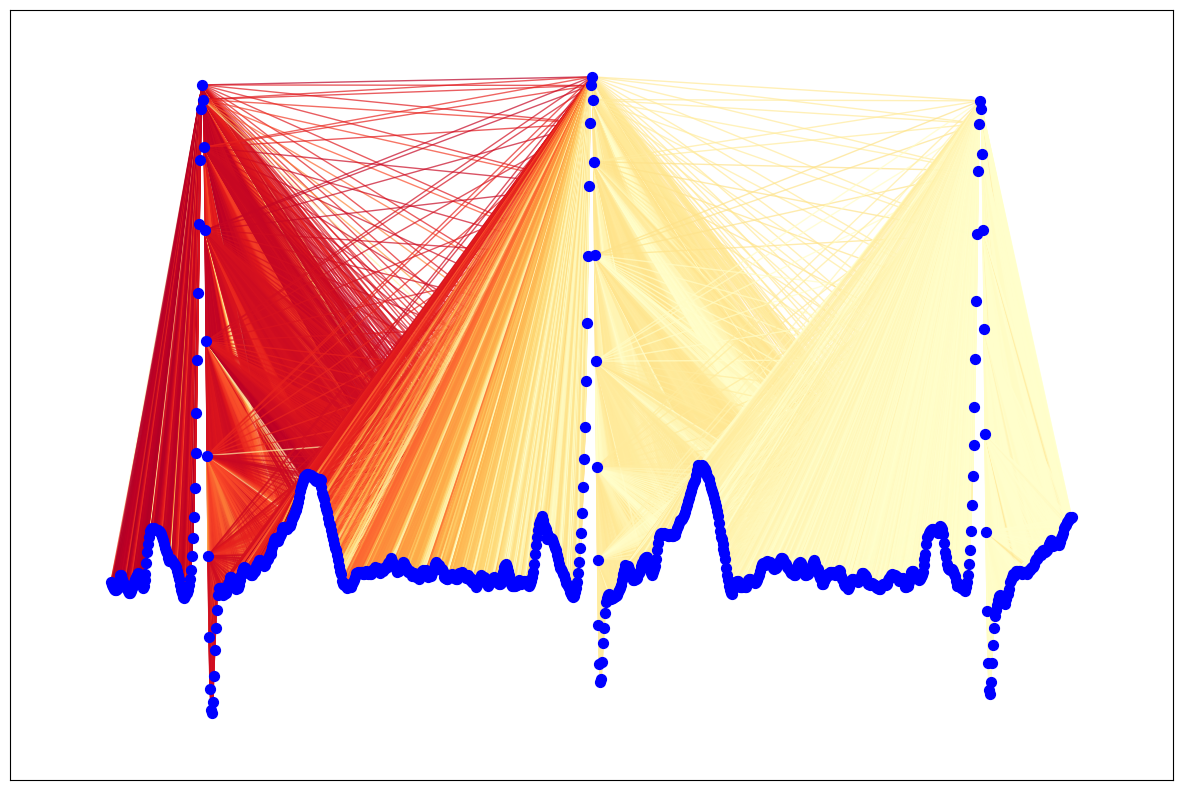

In [5]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
import matplotlib.colors as mcolors

def visualizar_grafo_com_matplotlib(pt_path, exam_id):
    """
    Carrega o arquivo .pt contendo os grafos processados (com chave "grafo" e "label")
    e visualiza o grafo de um ECG específico para um dado exam_id, usando Matplotlib.
    Nesta visualização, os nós são posicionados de acordo com seu índice e o valor da amplitude
    (primeira coluna das features, que corresponde à amplitude da lead utilizada na criação do grafo).
    
    Args:
        pt_path (str): Caminho para o arquivo .pt contendo os grafos.
        exam_id (str/int): O ID do exame.
    """
    try:
        dados_salvos = torch.load(pt_path, map_location=torch.device('cpu'), weights_only=False)
        grafos_by_exam = dados_salvos['grafos']
    except Exception as e:
        print(f"Erro ao carregar o arquivo .pt: {e}")
        return

    if exam_id not in grafos_by_exam:
        print(f"Exam ID '{exam_id}' não encontrado nos dados salvos.")
        return

    exam_dict = grafos_by_exam[exam_id]
    label = exam_dict.get("label", "Sem Label")
    graph_data = exam_dict.get("grafo")
    if graph_data is None:
        print(f"Grafo não encontrado para o exame {exam_id}.")
        return

    edge_index = graph_data.edge_index  # Tensor de shape [2, num_edges]
    edge_attr = graph_data.edge_attr.cpu().numpy() if graph_data.edge_attr is not None else None
    node_features = graph_data.x  # Tensor de shape [num_nodes, 48]

    # Usa a primeira coluna (amplitude) para definir a posição dos nós
    amplitude = node_features[:, 4].cpu().numpy()
    edges = edge_index.cpu().numpy()

    num_nodes = len(amplitude)
    if edges.size > 0:
        max_node = int(max(np.max(edges[0]), np.max(edges[1])))
        if max_node >= num_nodes:
            print("Atenção: O vetor de amplitude não cobre todos os nós do grafo.")
            num_nodes = max_node + 1

    # Cria o grafo com NetworkX
    G = nx.Graph()
    G.add_nodes_from(range(num_nodes))
    if edges.size > 0:
        G.add_edges_from(zip(edges[0], edges[1]))

    print(f"Grafo do exam_id {exam_id} criado com {G.number_of_nodes()} nós e {G.number_of_edges()} arestas.")

    # Define as posições: x = índice do nó, y = amplitude
    pos = {i: (i, amplitude[i]) for i in range(len(amplitude))}

    # Normaliza os pesos das arestas para mapeamento de cores
    if edge_attr is not None:
        norm = mcolors.Normalize(vmin=min(edge_attr), vmax=max(edge_attr))
        cmap = plt.cm.YlOrRd  # Amarelo → Vermelho
        edge_colors = [cmap(norm(weight)) for weight in edge_attr]
    else:
        edge_colors = "gray"  # Caso sem pesos

    # Plotagem
    plt.figure(figsize=(15, 10))
    nx.draw_networkx_edges(G, pos, alpha=0.7, edge_color=edge_colors, width=1)
    nx.draw_networkx_nodes(G, pos, node_size=50, node_color='blue')

    # Adicionar barra de cores
    if edge_attr is not None:
        sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
        sm.set_array([])
        cbar = plt.colorbar(sm, fraction=0.03, pad=0.02)
        cbar.set_label("Peso das Arestas")

    plt.title(f"Visualização do Grafo\nExam ID: {exam_id} | Label: {label}")
    plt.xlabel("Índice do Nó")
    plt.ylabel("Amplitude")
    plt.grid(True)
    plt.show()


def visualizar_apenas_grafo_com_matplotlib(pt_path, exam_id):
    """
    Carrega o arquivo .pt contendo os grafos processados (com chave "grafo" e "label")
    e visualiza apenas o grafo de um ECG específico para um dado exam_id, utilizando o layout automático do NetworkX.
    Exibe também a label associada ao exame.
    
    Args:
        pt_path (str): Caminho para o arquivo .pt contendo os grafos.
        exam_id (str/int): O ID do exame.
    """
    try:
        dados_salvos = torch.load(pt_path, map_location=torch.device('cpu'), weights_only=False)
        grafos_by_exam = dados_salvos['grafos']
    except Exception as e:
        print(f"Erro ao carregar o arquivo .pt: {e}")
        return

    if exam_id not in grafos_by_exam:
        print(f"Exam ID '{exam_id}' não encontrado.")
        return

    exam_dict = grafos_by_exam[exam_id]
    label = exam_dict.get("label", "Sem Label")
    graph_data = exam_dict.get("grafo")
    if graph_data is None:
        print(f"Grafo não encontrado para o exame {exam_id}.")
        return

    edge_index = graph_data.edge_index  # Tensor de shape [2, num_edges]
    edge_attr = graph_data.edge_attr.cpu().numpy() if graph_data.edge_attr is not None else None
    edges = edge_index.cpu().numpy()

    # Cria o grafo utilizando apenas as arestas
    G = nx.Graph()
    if edges.size > 0:
        G.add_edges_from(zip(edges[0], edges[1]))

    print(f"Grafo do exam_id {exam_id} criado com {G.number_of_nodes()} nós e {G.number_of_edges()} arestas.")

    # Layout automático (spring layout)
    pos = nx.spring_layout(G, seed=42)

    # Normaliza os pesos das arestas para mapeamento de cores
    if edge_attr is not None:
        norm = mcolors.Normalize(vmin=min(edge_attr), vmax=max(edge_attr))
        cmap = plt.cm.YlOrRd  # Amarelo → Vermelho
        edge_colors = [cmap(norm(weight)) for weight in edge_attr]
    else:
        edge_colors = "gray"  # Caso sem pesos

    # Plotagem
    plt.figure(figsize=(15, 10))
    nx.draw_networkx_edges(G, pos, alpha=0.7, edge_color=edge_colors, width=1)
    nx.draw_networkx_nodes(G, pos, node_size=50, node_color='blue')

    # Adicionar barra de cores
    if edge_attr is not None:
        sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
        sm.set_array([])
        cbar = plt.colorbar(sm, fraction=0.03, pad=0.02)
        cbar.set_label("Peso das Arestas")

    plt.title(f"Visualização Automática do Grafo\nExam ID: {exam_id} | Label: {label}")
    plt.axis("off")
    plt.show()


if __name__ == "__main__":
    # Caminho para o arquivo .pt gerado pelo processamento dos exames
    pt_path = "/scratch/luisagontijo/Clustering-Paper/Grafo/dataset/dataset_with_weights.pt"

    
    # Defina o exam_id que deseja visualizar (certifique-se de que o exam_id exista no arquivo salvo)
    exam_id = 271011  # Exemplo: utilize um exam_id presente em seus dados
    
    # Visualiza o grafo com os nós posicionados de acordo com o índice e a amplitude
    visualizar_grafo_com_matplotlib(pt_path, exam_id)
    
    # Visualiza apenas o grafo utilizando o layout automático
    visualizar_apenas_grafo_com_matplotlib(pt_path, exam_id)
